# REINFORCE Algorithm In Policy Gradient Methods
Implementation of REINFORCE to solve OpenAI Gym's CartPole environment.

Policy gradient methos are very similar to supervised learning.
The dataset varies by episode. so we use the policy to collect an episode, that gives up a Dataset or a bunch of matched state action pairs, and then we use that data set once to do a batch of updates. After those updates are done, we will discard the dataset and then collect another episode which gives us another dataset and so on.

In the implementation, each trajectory corresponds to a full episode, and we collect m=1 trajectories.

### Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40)# * suppress warnings

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400,900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Specify the Environment, and Explore the State and Action Spaces
Create an environment and set random seed

In [2]:

# Create an environment and set random seed
env = gym.make('CartPole-v1')
env.seed(0)
torch.manual_seed(0)

# Explore state (observation) space
print("State space: ", env.observation_space)
print("State shape: ", env.observation_space.shape)
print("- low: ", env.observation_space.low)
print("- high: ", env.observation_space.high)
print("")
# Generate some samples from the state space 
print("State space samples: \n", np.array([env.observation_space.sample() for i in range(10)]))

print("\n\n")

# Explore the action space
print("Action space:", env.action_space)
print("Action shape:", env.action_space.shape)
# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

State space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
State shape:  (4,)
- low:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
- high:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]

State space samples: 
 [[ 2.7017179e+00 -1.6902301e+38  3.1281418e-01 -1.5271087e+38]
 [-2.9043288e+00 -2.7898825e+37 -3.7690887e-01  8.0335156e+37]
 [-2.3042202e+00 -6.8004627e+37  3.4367836e-01 -1.4089729e+38]
 [ 3.1407893e+00 -4.1844946e+37  8.4700510e-02  1.9894041e+37]
 [-4.7194571e+00 -2.8957397e+38 -3.9827847e-01 -2.9486322e+38]
 [ 3.6586030e+00  1.6785788e+38  9.0240270e-02 -1.9531441e+38]
 [ 1.5836556e+00 -3.2957198e+38 -3.1317246e-01 -2.1368003e+37]
 [ 6.9215071e-01  1.0632636e+38 -1.5940155e-01  1.0280529e+38]
 [ 2.1004057e+00  1.8171825e+37  1.8791193e-01  1.6120563e+38]
 [ 4.1341075e-01  5.8655360e+37 -7.9865269e-02 -4.5683029e+37]]



Action space: Discrete(2)
Actio

### Define the Architecture of the Policy

In [3]:
###########################################
env = gym.make('CartPole-v0')
env.seed(0)

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        '''
        Return actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
        '''
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
    
    

# Build a Agent with REINFORCE to Train


In [4]:
def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)                  # Collect log probs
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)] # Set discount rate
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        # monitor
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
        

# Begin Training

In [5]:
# Set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

scores = reinforce()

Episode 100	Average Score: 34.47
Episode 200	Average Score: 66.26
Episode 300	Average Score: 87.82
Episode 400	Average Score: 72.83
Episode 500	Average Score: 172.00
Episode 600	Average Score: 160.65
Episode 700	Average Score: 167.15
Environment solved in 691 episodes!	Average Score: 196.69


### Plot Scores


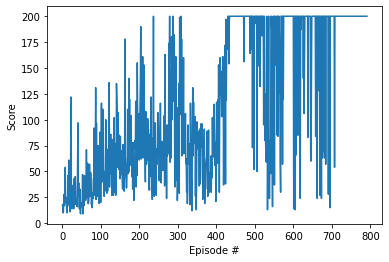

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Simulate Trained Agent

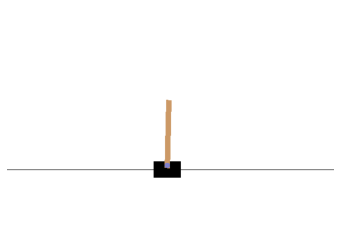

In [8]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()